In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from itertools import chain
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('Dataset11-Weather-Data.csv')
data.head()

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog


In [4]:
data.shape, data.columns, data.dtypes

((8784, 8),
 Index(['Date/Time', 'Temp_C', 'Dew Point Temp_C', 'Rel Hum_%',
        'Wind Speed_km/h', 'Visibility_km', 'Press_kPa', 'Weather'],
       dtype='object'),
 Date/Time            object
 Temp_C              float64
 Dew Point Temp_C    float64
 Rel Hum_%             int64
 Wind Speed_km/h       int64
 Visibility_km       float64
 Press_kPa           float64
 Weather              object
 dtype: object)

In [5]:
data.Weather.value_counts(), data.Weather.unique(), data.Weather.nunique()


(Weather
 Mainly Clear                               2106
 Mostly Cloudy                              2069
 Cloudy                                     1728
 Clear                                      1326
 Snow                                        390
 Rain                                        306
 Rain Showers                                188
 Fog                                         150
 Rain,Fog                                    116
 Drizzle,Fog                                  80
 Snow Showers                                 60
 Drizzle                                      41
 Snow,Fog                                     37
 Snow,Blowing Snow                            19
 Rain,Snow                                    18
 Thunderstorms,Rain Showers                   16
 Haze                                         16
 Drizzle,Snow,Fog                             15
 Freezing Rain                                14
 Freezing Drizzle,Snow                        11
 Freezing D

In [6]:
def Create_list(x):
    list_of_lists = [w.split() for w in x.split(',')]
    flat_list = list(chain(*list_of_lists))
    return flat_list

In [7]:
def Get_Weather(list1):
    if 'Fog' in list1 and 'Rain' in list1:
        return 'RAIN+FOG'
    elif 'Snow' in list1 and 'Rain' in list1:
        return 'SNOW+RAIN'
    elif 'Snow' in list1:
        return 'SNOW'
    elif 'Rain' in list1:
        return 'RAIN'
    elif 'Fog' in list1:
        return 'FOG'
    elif 'Clear' in list1:
        return 'Clear'
    elif 'Cloudy' in list1:
        return 'Cloudy'
    else:
        return 'RAIN'

In [8]:
data['Std_Weather'] = data['Weather'].apply(lambda x: Get_Weather(Create_list(x)))

Cloudy_df = data[data['Std_Weather'] == 'Cloudy'].sample(600)
Clear_df = data[data['Std_Weather'] == 'Clear'].sample(600)
Rain_df = data[data['Std_Weather'] == 'RAIN']
Snow_df = data[data['Std_Weather'] == 'SNOW']

In [9]:
Cloudy_df_sample = Cloudy_df.sample(600)
Weather_df = pd.concat([Cloudy_df_sample, Clear_df, Rain_df, Snow_df], axis=0)

In [10]:
Weather_df.drop(columns=['Date/Time', 'Weather', 'Dew Point Temp_C', 'Visibility_km'], axis=1, inplace=True)

In [11]:
Weather_df.isnull().sum(), Weather_df.duplicated().sum()

(Temp_C             0
 Rel Hum_%          0
 Wind Speed_km/h    0
 Press_kPa          0
 Std_Weather        0
 dtype: int64,
 0)

<Axes: >

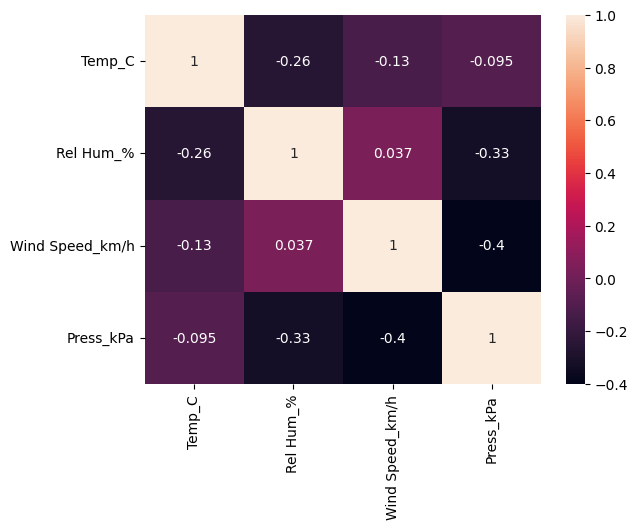

In [12]:
Weather_df.describe()
cols = ['Temp_C', 'Rel Hum_%', 'Wind Speed_km/h', 'Press_kPa']
cor_matrix = Weather_df[cols].corr()
sns.heatmap(cor_matrix, annot=True)

<Axes: title={'center': 'Press_kPa'}>

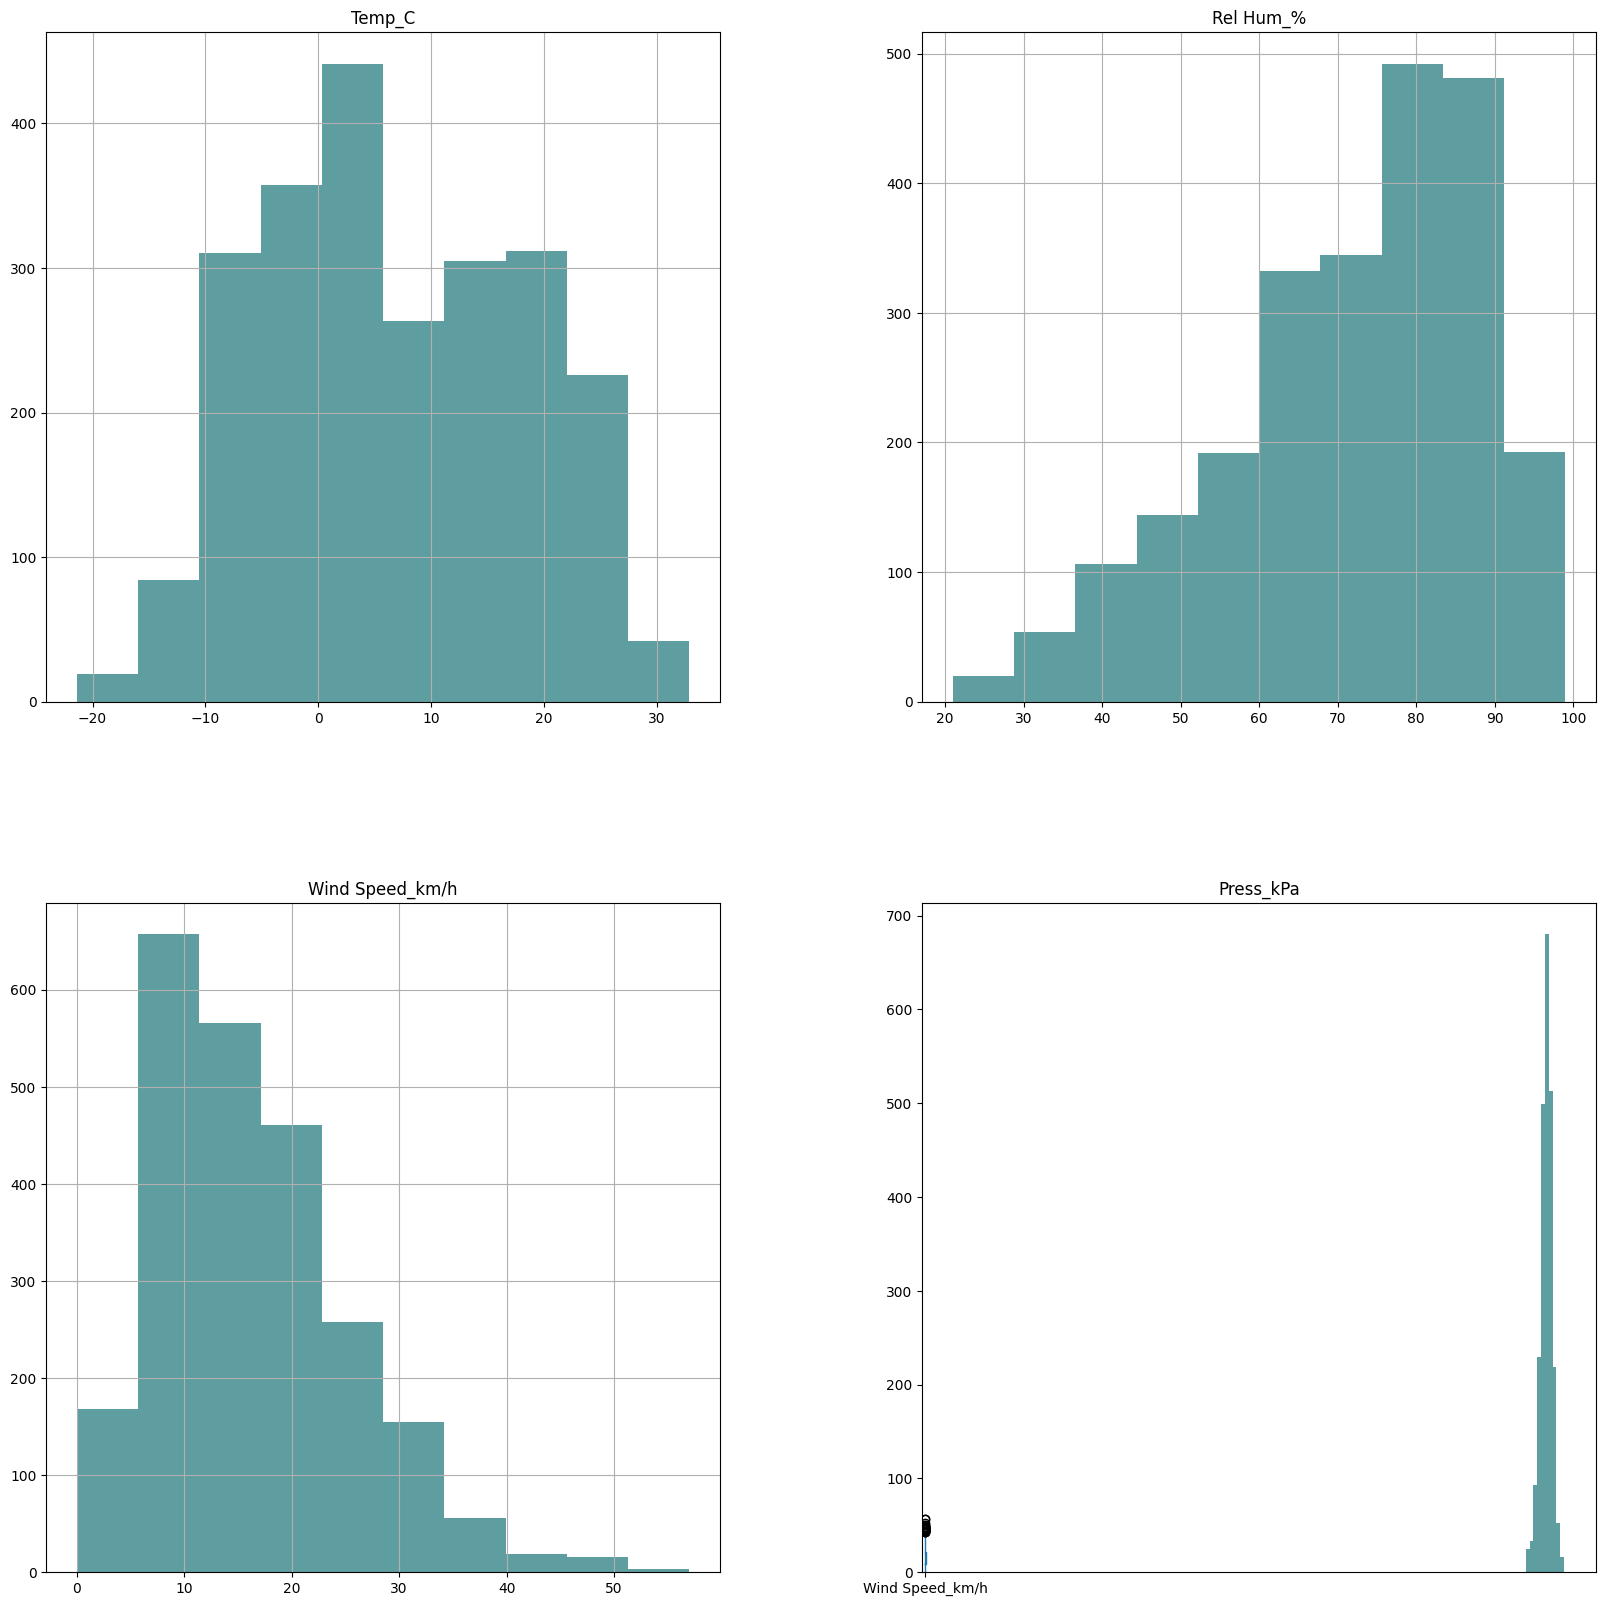

In [13]:
Weather_df.hist(figsize=(20, 20), color="#5F9EA0")

Weather_df['Wind Speed_km/h'].plot(kind='box')

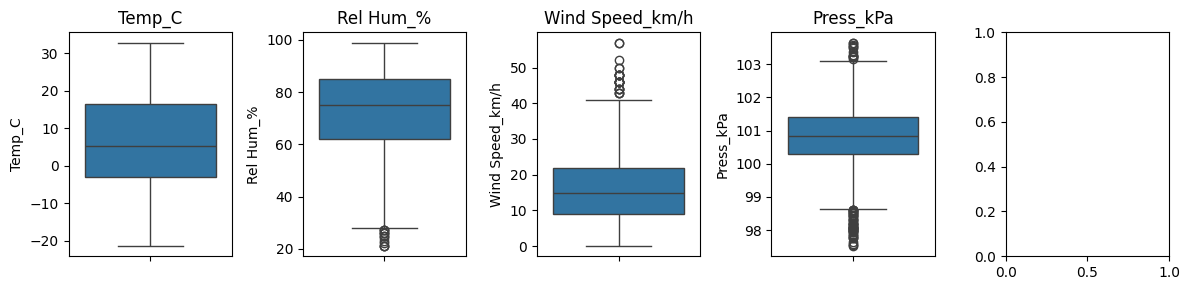

In [14]:
num_cols = Weather_df.select_dtypes(exclude=['object']).columns.tolist()
fig, axes = plt.subplots(ncols=5, figsize=(12, 3))
for column, axis in zip(num_cols, axes):
    sns.boxplot(data=Weather_df[column], ax=axis)
    axis.set_title(column)
plt.tight_layout()
plt.show()

In [15]:
label_Encoder = LabelEncoder()
Weather_df['Std_Weather'] = label_Encoder.fit_transform(Weather_df['Std_Weather'])

X = Weather_df.drop(['Std_Weather'], axis=1)
y = Weather_df['Std_Weather']

std_scalar = StandardScaler()
X_std = std_scalar.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)


In [16]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Naive Bayes': GaussianNB()
}

accu_list = []
ModelName = []
CV = 5
for model_name, model in models.items():
    accuracies = cross_val_score(model, X_std, y, scoring='accuracy', cv=CV)
    accu_list.append(accuracies.mean() * 100)
    ModelName.append(model_name)

model_acc_df = pd.DataFrame({"Model": ModelName, "Cross_Val_Accuracy": accu_list})
model_acc_df.sort_values(by=['Cross_Val_Accuracy'], ascending=False)

,Model,Cross_Val_Accuracy
6,Gradient Boosting,57.950898
0,Logistic Regression,57.484346
8,Naive Bayes,56.932329
2,Random Forest,56.468387
4,SVM,55.789341
3,Extra Trees,55.026719
7,AdaBoost,51.633110
5,KNN,51.296376
1,Decision Tree,51.126525


In [17]:
best_model = RandomForestClassifier()

best_model.fit(x_train, y_train)

RandomForestClassifier()

Best Model: Random Forest
              precision    recall  f1-score   support

           0       0.60      0.65      0.63       118
           1       0.50      0.42      0.46       128
           2       0.69      0.67      0.68       126
           3       0.73      0.82      0.77       100

    accuracy                           0.63       472
   macro avg       0.63      0.64      0.63       472
weighted avg       0.62      0.63      0.63       472



<Axes: >

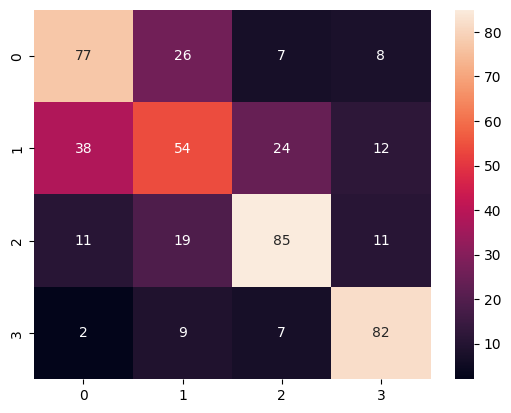

In [19]:
y_pred_best = best_model.predict(x_test)
print(f"Best Model: Random Forest")
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d')

In [20]:
pickle.dump(best_model, open('best_model.pkl', 'wb'))
pickle.dump(std_scalar, open('scaler.pkl', 'wb'))

model = pickle.load(open('best_model.pkl', 'rb'))
scaler = pickle.load(open('scaler.pkl', 'rb'))

In [23]:
Temp = float(input("Enter the temperature : "))
rh = float(input("Enter the Relative humidity(%) : "))
ws = float(input("Enter the Wind Speed(km/hr) : "))
pr = float(input("Enter the Pressure(Kpa) : "))

input_data = [Temp, rh, ws, pr]
scaled_data = scaler.transform([input_data])
prediction = model.predict(scaled_data)

if prediction[0] == 0:
    print('Weather is "CLEAR"')
elif prediction[0] == 1:
    print('Weather is "CLOUDY"')
elif prediction[0] == 2:
    print('Weather is "RAINY"')
else:
    print('Weather is "SNOWY"')

Enter the temperature : 17.53
Enter the Relative humidity(%) : 46
Enter the Wind Speed(km/hr) : 5.62
Enter the Pressure(Kpa) : 101.7
Weather is "CLEAR"
